# High-Throughput Materials Discovery Tutorial
## Finding Novel Garnet Substrates for YIG Spintronics

### Tutorial Overview

In this tutorial, we will try identify novel garnet substrates suitable for **Yttrium Iron Garnet (YIG)** spintronics applications. YIG is an important material in research for spintronic devices due to its exceptional magnetic properties. However, finding compatible metallic substrates remains a significant challenge. We are looking for a new metallic garnet whose lattice closely matches the YIG lattice constants.

### The Challenge

The ideal substrate must be:
- **Thermodynamically and dynamically stable**, i.e. close to the convex hull and free of imaginary phonon modes  
- **Reasonably safe to work with** in terms of elemental composition  
- **Lattice-matched** to YIG to optimize epitaxial growth  
- **Metallic** or possess a **small band gap**


We will construct a computational pipeline that combines:

1. Database Mining  
   Use the OPTIMADE API to search crystal-structure repositories for garnets. This leverages existing calculations and also allows us to validate the rest of our workflow.

2. - Generate new garnet compositions via a combinatorial approach.  
   - Relax each candidate using Atomate2 workflows to evaluate thermodynamic stability.  
   - For any promising, low-energy structures, evaluate dynamic stability (e.g., phonon calculations).  
   - Employ universal machine-learning force fields as a DFT surrogate to accelerate relaxation, given the large unit cell of garnets.  
   - Then apply a second set of machine-learning models to predict the band gap.

3. Rank all candidates based on thermodynamic stability, lattice matching, and band gap.  

While we will not explore hundreds of thousands of candidates we will make sure that the pipeline will automatically scale to this number.  


Let's begin by understanding how to access and query materials databases using the OPTIMADE standard.

There are different ways to access databases throught optimade, directly sending requests to the database providers using e.g. the `requests` library, using pymatgen.ext.optimade, or using the optimade-python-tools package. [These tutorials](https://github.com/Materials-Consortia/optimade-tutorial-exercises) explore all three options.
We are going to use the OptimadeClient package.


# Introduction to OPTIMADE
In materials research, data is scattered across numerous experimental and theoretical databases maintained by different institutions.
Example theoretical databases that host inorganic crystal structures are:
- Materials Project
- Alexandria
- AFLOW
- OQMD (Open Quantum Materials Database)
- NOMAD
- And many others

OPTIMADE solves the "database fragmentation" problem by allowing you to:
- Query multiple databases using the same syntax
- Retrieve data in a consistent format

**What is OPTIMADE?**

The [**Open Databases Integration for Materials Design (OPTIMADE)**](https://www.optimade.org/) is a standardized API specification that enables access to materials databases from different providers. Instead of learning different query languages and data formats for each database, OPTIMADE provides a unified interface to search across multiple materials science repositories. Once a workflow is established for one database it can easily be extended to multiple databases such as in [Accelerating the discovery of high-performance nonlinear optical materials using active learning and high-throughput screening](https://arxiv.org/abs/2504.01526).

## Key Concepts

**Structures**: The primary entries in most OPTIMADE databases, representing crystal structures with properties like:
- Chemical composition
- Lattice parameters
- Atomic positions

One weakness at the moment is that other properties such as band gaps usually have database specific names.

**Warning: While Optimade provides a common interface the calculation parameters of most databases are not compatible! Even quantities such as space groups might be calculated using different tolerances.**



The power of OPTIMADE lies in its ability to query multiple databases simultaneously. In principle, we can directly query all available databases with a single command, as shown in the example below:

```python
from optimade.client import OptimadeClient

# Initialize the OPTIMADE client
client = OptimadeClient()

# Query all databases for structures 
results = client.get('elements HAS "Li" AND nelements=2') #containing Li, with 2 different elements
```

This approach would systematically search through all 59 million crystal structures hosted by the 27 [OPTIMADE-compliant databases](https://www.optimade.org/providers-dashboard/) and return structures containing Lithium and one other element. The query filters are written in an SQL-like synthax.

However, querying all available databases simultaneously comes with practical limitations:

- **Time complexity**: A comprehensive search across all databases can take several hours depending on the query complexity
- **Rate limiting**: Different databases have varying rate limits and response times
- **Network reliability**: Some databases may be temporarily unavailable, affecting the completeness of results

For this tutorial, we will limit ourselves to a few of the largest providers with open licenses:

- **OQMD**
- **Alexandria**


In [ ]:
import pickle

from optimade.adapters import Structure as opt_Structure
from optimade.client import OptimadeClient
from pymatgen.core import Structure as pmg_Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatviz import count_elements, ptable_heatmap
from tqdm import tqdm

In [ ]:
client = OptimadeClient(
    base_urls=["https://oqmd.org/optimade", "https://alexandria.icams.rub.de/pbe"],
    use_async=False,
    max_results_per_provider=10,
)

We can take a look at the properties that are available for each provider:

In [ ]:
properties = client.list_properties("structures")
print(properties)

We can leverage standardized property names—such as chemical_formula_reduced—to query multiple databases for the same criterion while database specific properties start with the provider prefix, e.g. `_alexandria_band_gap`.

To start, we can query both OQMD and Alexandria for YIG (Y₃Fe₅O₁₂) by filtering on its reduced formula:

In [9]:
yig_query = 'chemical_formula_reduced="Y3Fe5O12"'
response_yig = client.get(filter=yig_query)

╭─────────────────────────────────────────────────────────────────────────╮
│ Performing query structures/?filter=chemical_formula_reduced="Y3Fe5O12" │
╰─────────────────────────────────────────────────────────────────────────╯

In [ ]:
print(
    response_yig["structures"]['chemical_formula_reduced="Y3Fe5O12"'][
        "https://oqmd.org/optimade"
    ].keys()
)

dict_keys(['data', 'errors', 'links', 'included', 'meta'])


The response is in the form of a dictionary.
The first key is the name of the **endpoint**. The most common endpoint is **structures** that returns a list of structures entries. 
The next key specifies the query followed by the provider.
Under the **meta** key we find some information about the response, e.g. for OQMD:

```python
'meta': {
    'query': {
        'representation': '/structures?filter=chemical_formula_reduced=%22Y3Fe5O12%22'
    },
    'data_returned': 3,       # Found 3 YIG structures
    'data_available': 1226781,  # Total structures in OQMD
    'more_data_available': False  # All matching results returned
}
```
By default, all fields are returned. If we only want specific fields, we can request them via `response_fields`, for example:

```python
response = client.get(
    yig_query,
    response_fields=["lattice_vectors"]
)
```
The client will cache previous query results and you will be able to access them under client.all_results.

We can filter specifically for a thermodynamically stable Y₃Fe₅O₁₂ structure by requiring oqmd_stability = 0. In this context, “stability” measures the energy above the convex hull and is supported by several DFT databases. However, that not all providers use the same field name—for instance, Alexandria still uses _alexandria_hull_distance instead of stability. You can use client.search_property to discover each provider’s property names across different databases.

In [ ]:
yig_query = 'chemical_formula_reduced="Y3Fe5O12" AND _oqmd_stability=0'
response_yig = client._get_all(
    endpoint="structures", filter=yig_query, base_urls=["https://oqmd.org/optimade"]
)

In [ ]:
yig_structure_attributes = response_yig["https://oqmd.org/optimade"].data[0]["attributes"]
print(
    f'Entry ID: {yig_structure_attributes["_oqmd_entry_id"]} '
    f'with ICSD-ID: {yig_structure_attributes["_oqmd_icsd_id"]} '
    f'has a distance to the convex hull of {yig_structure_attributes["_oqmd_stability"]} '
    f'eV/atom with space group {yig_structure_attributes["_oqmd_spacegroup"]}\n'
    f'and lattice parameters {yig_structure_attributes["lattice_vectors"]}'
)

We have found a stable crystal structure of Y₃Fe₅O₁₂, and OQMD also provides a reference ID in the experimental ICSD database. Looking through the query results, we can also see the correct cubic space group Ia-3d (230). As a next step, we will query the two databases for all other garnets with the same general composition A₁₂B₅C₃ and space group Ia-3d (230).

In [ ]:
garnet_query = (
    'chemical_formula_anonymous="A12B5C3" AND '
    '(_alexandria_space_group=230 OR _oqmd_spacegroup="Ia-3d")'
)
response_oqmd = client._get_all(
    endpoint="structures", filter=garnet_query, base_urls=["https://oqmd.org/optimade"]
)
response_alexandria = client._get_all(
    endpoint="structures",
    filter=garnet_query,
    base_urls=["https://alexandria.icams.rub.de/pbe"],
)

As written in the client response, Alexandria has more entries than our max_results_per_provider setting allows. Outside of a Jupyter notebook, we could use the client.count(filter) method with asynchronous queries to count the results. Since obtaining the full response would take a while, we are providing a pickle of the response that you can load.
To work with the response data, we can either reconstruct a pymatgen Structure object by hand:

In [ ]:
response_yig_attributes = response_yig["https://oqmd.org/optimade"].data[0]["attributes"]
yig_structure = pmg_Structure(
    lattice=response_yig_attributes["lattice_vectors"],
    species=response_yig_attributes["species_at_sites"],
    coords=response_yig_attributes["cartesian_site_positions"],
    coords_are_cartesian=True,
)
yig_conventional = SpacegroupAnalyzer(yig_structure).get_conventional_standard_structure()
yig_conventional.lattice

or use the Structure class in optimade to convert the structural information into any other common format, e.g., from ase or pymatgen.

In [ ]:
response_alexandria = pickle.load(open("../data/garnet_alexandria.pickle", "rb"))
data = response_alexandria["https://alexandria.icams.rub.de/pbe"].data
structures = [opt_Structure(structure).convert("pymatgen") for structure in data]
# Extracting energies, band gaps, and hull distances from the Alexandria response
energies_alexandria = [
    structure["attributes"]["_alexandria_energy"] for structure in data
]
band_gaps_alexandria = [
    structure["attributes"]["_alexandria_band_gap"] for structure in data
]
ehull_alexandria = [
    structure["attributes"]["_alexandria_hull_distance"] for structure in data
]

Pymatviz provides very useful tools to visualize large materials datasets. For example, we can plot the elemental distribution of the garnets using the `ptable_heatmap` function together with the `count_elements` utility.
We use `count_mode="occurrence"` to only count each element once per structure.

/tmp/ipykernel_767119/1592970798.py:3: UserWarning: default value of fill_value changed from zero to None.
  element_counts = count_elements(compositions, count_mode="occurrence")
/home/sjonathan/anaconda3/envs/fireworks_mp/lib/python3.11/site-packages/pymatviz/ptable/_process_data.py:117: UserWarning: NaN found in data
  self.check_and_replace_missing(strategy=missing_strategy)
/tmp/ipykernel_767119/1592970798.py:4: FutureWarning: We return_type='figure' over return_type='axes' for more consistent results.
This will become the default after 2025-07.
  fig = ptable_heatmap(element_counts, log=True)


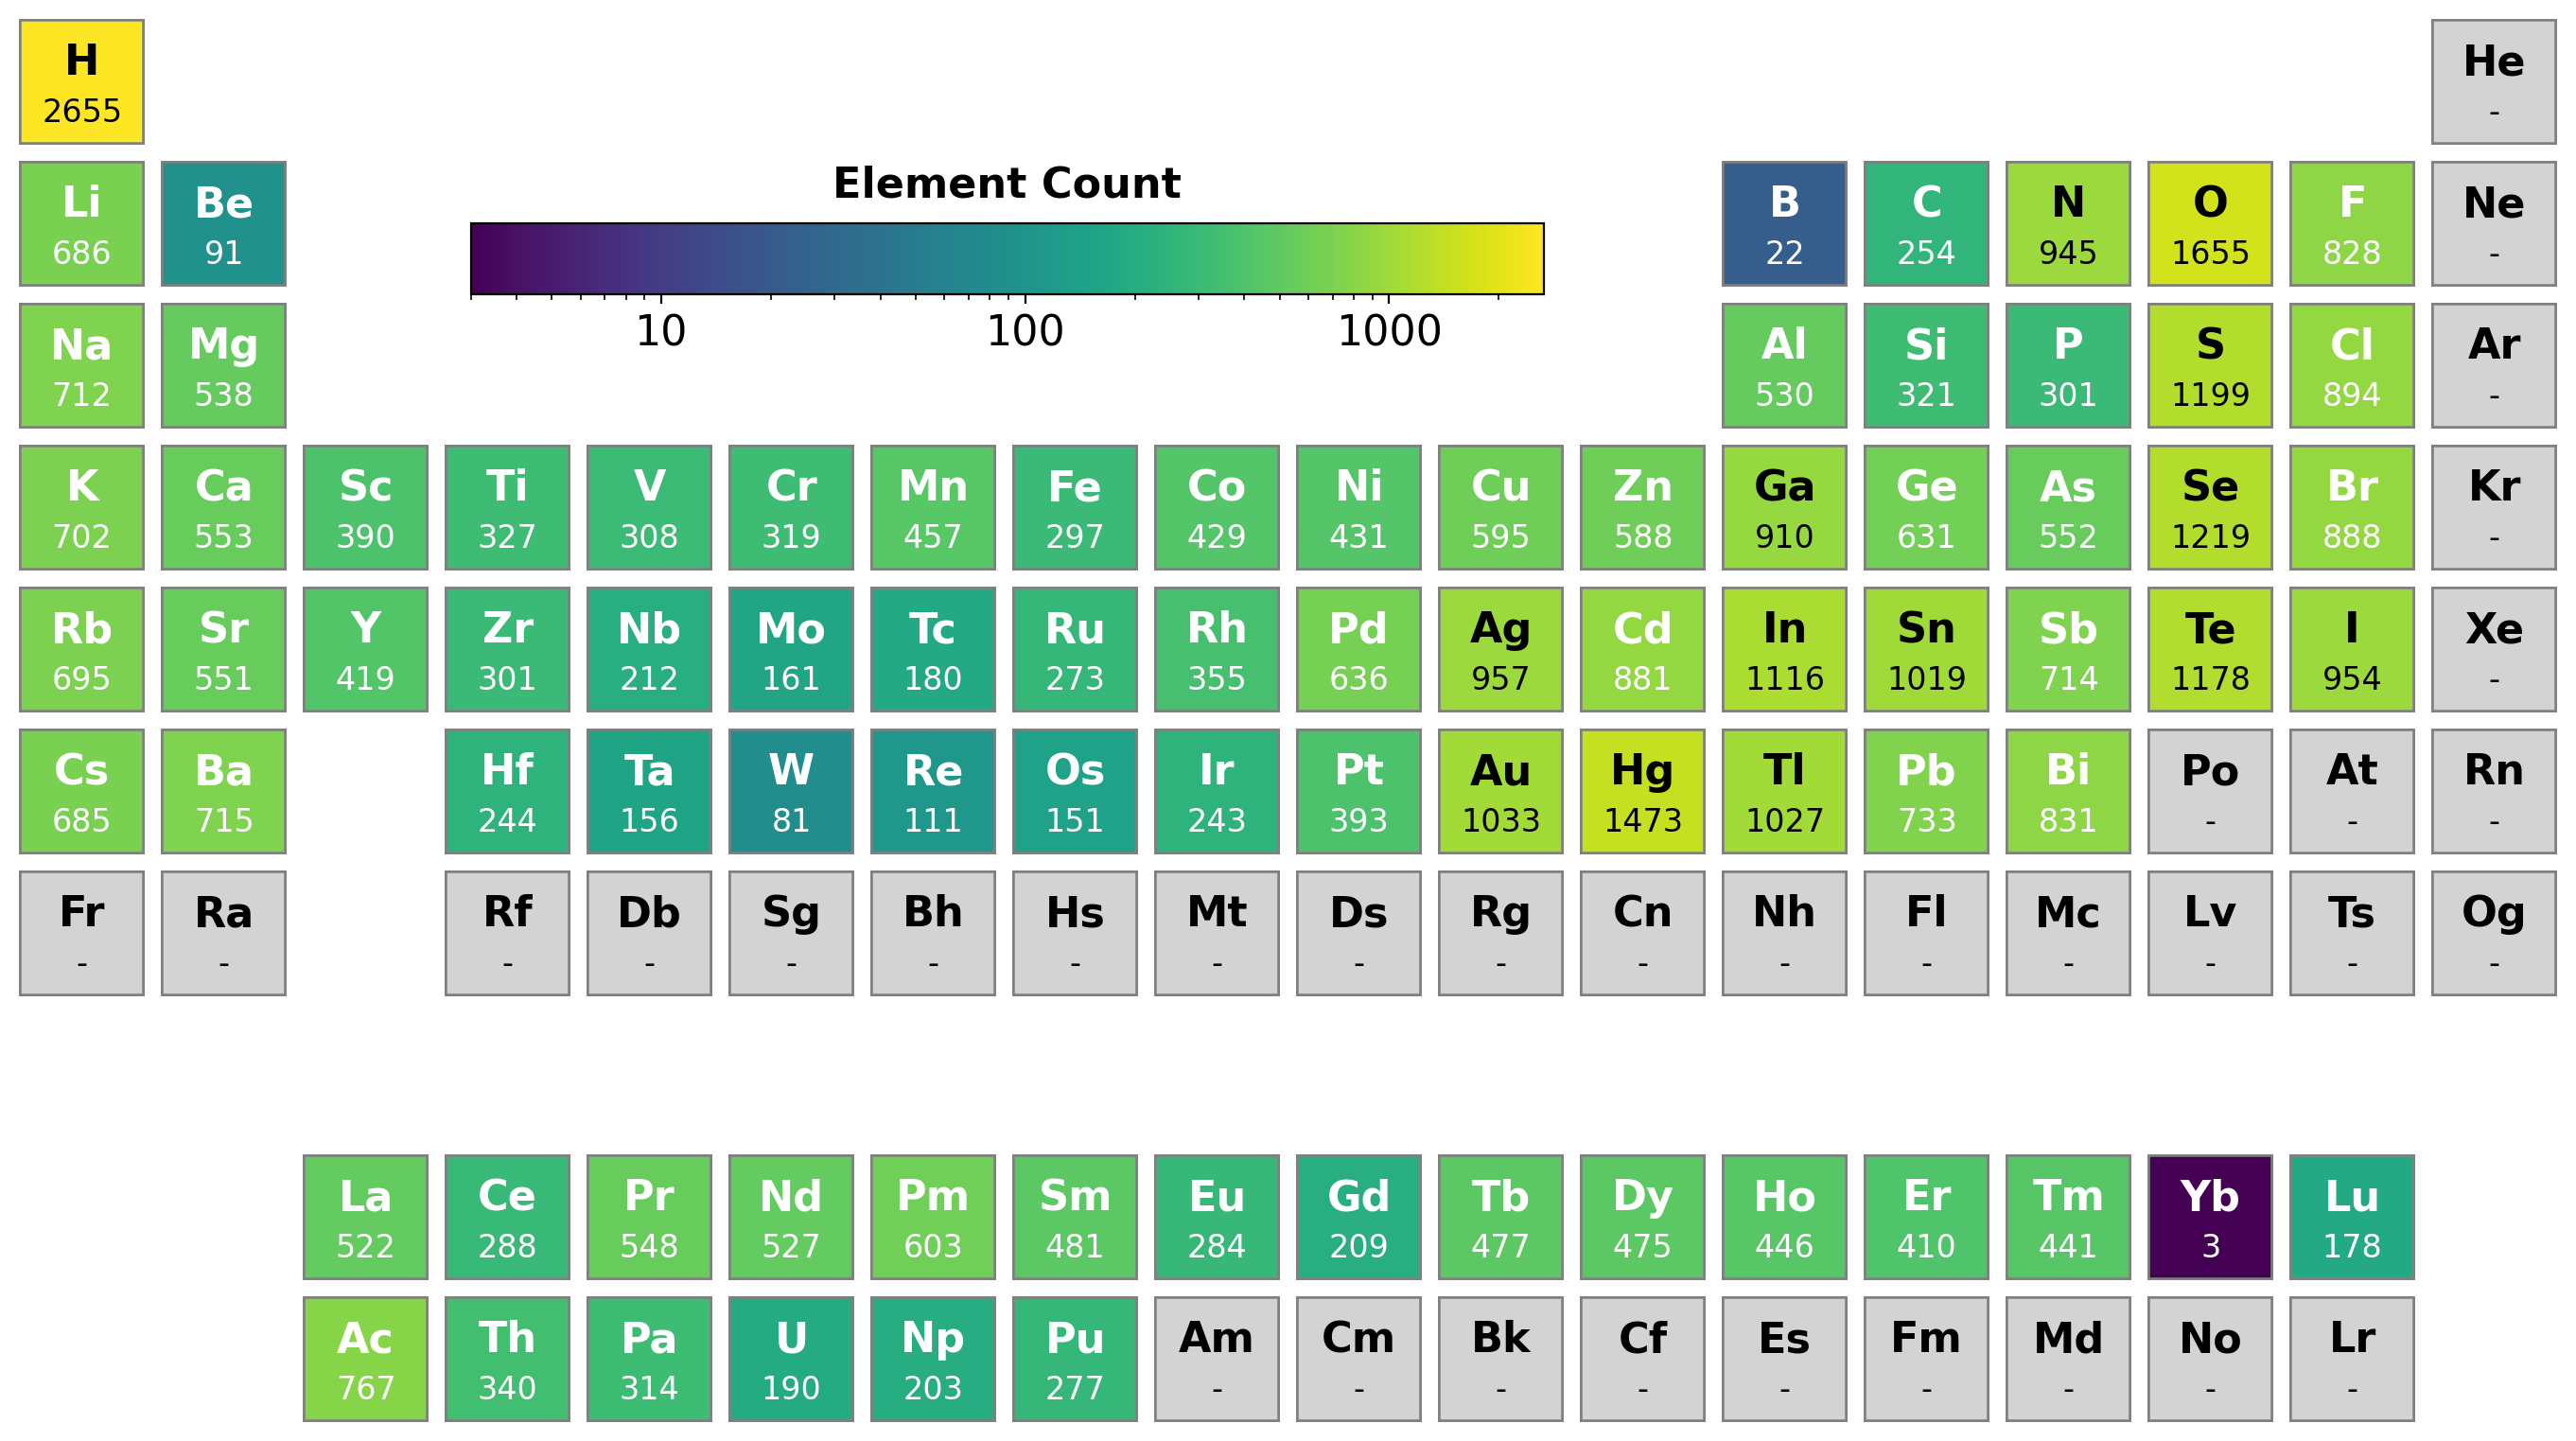

In [ ]:
compositions = [structure.reduced_formula for structure in structures]
element_counts = count_elements(compositions, count_mode="occurrence")
fig = ptable_heatmap(element_counts, log=True)

We can now filter structures by band gap, hull distance, and lattice parameters to identify candidates that meet our criteria. For example, we might start by selecting metallic structures (band gap ≈ 0) with a hull distance below 0.05 eV/atom and lattice constants within 1 Å of our target values. We will use the conventional standard structure to have consistent lattice definition.

In [ ]:
max_band_gap_criterion = 0.3
max_ehull_criterion = 0.05
ideal_lattice_constant = yig_conventional.lattice.a
filtered_structures = []
for structure, energy, band_gap, ehull in tqdm(
    zip(structures, energies_alexandria, band_gaps_alexandria, ehull_alexandria),
    total=len(structures),
):
    lattice_a = (
        SpacegroupAnalyzer(structure).get_conventional_standard_structure().lattice.a
    )
    if (
        band_gap < max_band_gap_criterion
        and ehull < max_ehull_criterion
        and abs(lattice_a - ideal_lattice_constant) < 1.0
    ):
        filtered_structures.append(structure)
        filtered_structures[-1].data = {
            "energy": energy,
            "band_gap": band_gap,
            "ehull": ehull,
        }

We can now have another look at the filtered structures:

In [ ]:
compositions = [structure.reduced_formula for structure in filtered_structures]
element_counts = count_elements(compositions, count_mode="occurrence")
ax = ptable_heatmap(element_counts)

We see that the filtered structures are dominated by A₃B₅N₁₂. In the next tutorial, we will use automated workflows in combination with universal force fields to explore additional A₃B₅N₁₂ structures and evaluate their dynamic stability. In practice, we could use the data we downloaded to fine-tune the universal force field and other machine-learning models before continuing. However, you will learn how to fine-tune a force field in a separate tutorial and lecture, so we will skipt that step here.

## Exercises:
- Refine the OPTIMADE query to incorporate as many filtering criteria as possible, including excluding radioactive elements. You can also use the client’s callback feature to implement more advanced filtering logic.
- Create a periodic table plot where each element panel is split into three sections representing respectively the A, B and C  in the garnet composition A₃B₅C₁₂.